# Recognition of Gestures and Actions
- 사람의 Body Points(관절)을 감지하여 제스쳐와 동작을 구분하자

### 사용 데이터셋 MPII Human Pose Dataset : http://human-pose.mpi-inf.mpg.de/
- MPII Model: 인간의 움직임을 인식하도록 특별히 학습된 모듈 (유튜브 영상을 추출해서 학습했다.)
  - VGG 아키텍쳐(합성곱 신경망)를 사용하여 구성된다.
  - MPII와 이미지넷 데이터셋의 차이는 MPII는 사람의 포인트를 감지하고 이미지셋은 객체의 클래스를 분류하는것이다.
  - 추출 할 수 있는 인간의 body points 주로 사용하는건 0~15번까지이다. (원래는 더 있다.)
    - 0은 머리, 1은 목, 2는 오른쪽 어깨등 사람의 주요 관절을 감지하여 행동을 파악한다.

## Detecting Body Points

### Importing the libraries

In [3]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### Loading the image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/megan.jpg')

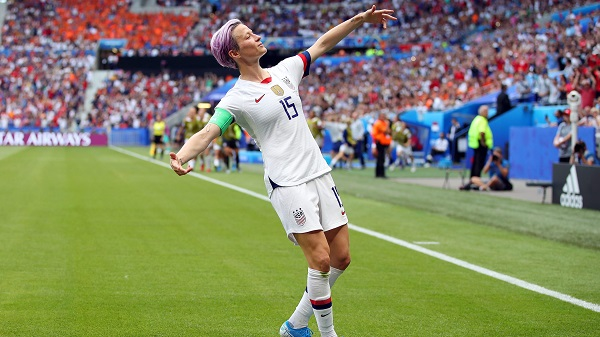

In [6]:
cv2_imshow(image)

In [7]:
# 이미지 shape, 전체 픽셀개수
image.shape, image.shape[0] * image.shape[1]* 3

((337, 600, 3), 606600)

### 이미지 모델에 전송하기(Blob)

 - 이미지를 모델에 전송하기위해 blob형식으로 바꿔야한다.
  - .blob: blob 형식은 바이너리 형식으로 큰 객체 ( 비디오, 이미지, 사운드 같은)를 저장하는 방식이다. 탄생 배경은 DB에서 정의되지 않은 형식의 데이터를 저장하기 위해 만들어진 형식이다. 기본적으로 용량이 큰 파일들은 여러 페이지(page,운영체제)로 나누어져서 저장되어지는것 보단 연결되어 관리되어지는게 편해서 blob을 사용하면 그것이 가능하다.
  - 딥러닝에선 이미지를 입력층으로 보낼때 주로 사용하는데 이진 데이터로 이미지의 픽셀 값, 크기, 채널 수를 관리하여 효율적으로 사용할수 있기때문이다.

In [8]:
type(image)

numpy.ndarray

In [9]:
# cv2.dnn.blobFromImage 이미지를 blob형식으로 변환
# 매개변수 : image- 이미지파일, scalefactor - 정규화 방식 , size=(너비,높이)
# Mean subtraction
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0/255,
                                   size = (image.shape[1],image.shape[0]))

In [10]:
# type은 같지만 shape이 이미지개수, 채널수, 높이, 너비로 바꼈다.
type(image_blob), image_blob.shape

(numpy.ndarray, (1, 3, 337, 600))

### Loading the pre-trained neural network
- 사전 학습된 모델 가져오기 caffe 프레임워크(darknet과 비슷한것)
- Caffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [11]:
# cv2.dnnreadNetFrom 함수에는 caffe, tensorflow, darknet등 다양한 딥러닝 프레임워크에서 만든 구조를 형식에 맞춰 cv2에서 사용할 수 있도록 변환해주는 함수이다.
# 대부분 매개변수는 ('신경망 구조 파일 경로', '가중치 파일 경로') 이다. caffe는 신경망 구조가 .prototxt 형식 가중치 구조가 .caffemodel 이다.
# cv2에 사전 학습된 신경망 이식
network = cv2.dnn.readNetFromCaffe("/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/pose_deploy_linevec_faster_4_stages.prototxt",
                                   "/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/pose_iter_160000.caffemodel")



In [12]:
network.getLayerNames() # 각각의 층의 이름을 출력

('conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1_stage1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2_stage1',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3_stage1',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3_CPM',
 'relu4_3_CPM',
 'conv4_4_CPM',
 'relu4_4_CPM',
 'conv5_1_CPM_L1',
 'relu5_1_CPM_L1',
 'conv5_1_CPM_L2',
 'relu5_1_CPM_L2',
 'conv5_2_CPM_L1',
 'relu5_2_CPM_L1',
 'conv5_2_CPM_L2',
 'relu5_2_CPM_L2',
 'conv5_3_CPM_L1',
 'relu5_3_CPM_L1',
 'conv5_3_CPM_L2',
 'relu5_3_CPM_L2',
 'conv5_4_CPM_L1',
 'relu5_4_CPM_L1',
 'conv5_4_CPM_L2',
 'relu5_4_CPM_L2',
 'conv5_5_CPM_L1',
 'conv5_5_CPM_L2',
 'concat_stage2',
 'Mconv1_stage2_L1',
 'Mrelu1_stage2_L1',
 'Mconv1_stage2_L2',
 'Mrelu1_stage2_L2',
 'Mconv2_stage2_L1',
 'Mrelu2_stage2_L1',
 'Mconv2_stage2_L2',
 'Mrelu2_stage2_L2',
 'Mconv3_stage2_L1',
 'Mrelu3_stage2_L1',
 'Mconv3_stage2_L2',
 'Mrelu3_stage2_L2',
 'Mconv4_stage2_L1',
 'Mrelu4_sta

In [13]:
len(network.getLayerNames())

127

### Predicting body points
- 이미지를 신경망에 입력하여 body point 추출하고 시각화하기.

In [14]:
# 이전에 변환한 blob형식의 이미지를 모델의 인풋레이어에 전송
network.setInput(image_blob)
# 예측 실행(tensorflow predict()와 유사, cv2에선 forward()를 쓴다)
output = network.forward()

In [15]:
output.shape # ('이미지 번호', 'body point', 'height', 'width')
# height과 width가 작아진이유는 예측중에 이미지의 크기가 변환되기때문이다.

(1, 44, 43, 75)

In [16]:
position_width = output.shape[3]
position_height = output.shape[2]

In [17]:
position_width # 너비의 총 크기

75

In [18]:
num_points = 15 # body point 번호(0~14까지)
points = []
threshold = 0.1
for i in range(num_points):
  # output은 4개의 차원이있다.(1, 44, 43, 75), output[]을 슬라이싱하면 각각의 차원에 접근할 수 있다
  # [[0,i, :, :]]는 0번째 이미지에서 i번째 bodypoint에 각각의 width,height의 확률들을 가져오겠다.
  confidence_map = output[0,i, :, :]
  # 43개의 높이마다 75개의 너비가 있고 각각의 너비들이 해당 bodypoint가 될 확률을 값으로 가지고있다
  # 이미지 높이 1:[이미지 너비1:[이미지 높이 1,이미지 너비 1 일때 bodypoint일 확률],이미지 너비2:[이미지 높이 1,이미지 너비 2 일때 bodypoint일 확률]]
  # 이미지 높이 2:[이미지 너비1:[이미지 높이 2,이미지 너비 1 일때 bodypoint일 확률],이미지 너비2:[이미지 높이 2,이미지 너비 2 일때 bodypoint일 확률]]
  # 이미지 높이와 너비가 기존보다 달라진 이유는 신경망에서 이미지의 크기를 변환하기 때문이다 -> 실제 이미지에 적용하기 위해 다시 알맞은 변형해야한다.
  # print(confidence_map.shape)
  # print(confidence_map)
  # print(len(confidence_map))
  # cv2.minMaxLoc()함수는 모든 값중 가장 크고 작은 값의 인덱스값을 반환해준다
  # 현재 confidence_map은 2차원 [높이][너비]로 이루어져있기때문에 max 및 min 값을 가지고 있는 index를 제공한다. ex.index = (32,1)
  # minVal, maxVal(confidenc, 값), minLoc, MaxLoc(point, 인덱스) = cv.minMaxLoc(src)
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  # 각각의 body point마다 하나의 confidence와 point가 나온다.
  print(confidence,point)

  # 이렇게 얻은 point(bodypoint의 좌표상 위치)는 실제 이미지에 적용할 수 없다. 왜냐하면 이것은 신경망에서 예측할때 축소된 이미지의 좌표이기 때문이다.
  # 변환방법
  # 실제 바디포인터 x축 위치 : 실제 이미지 총 너비(image.shape[1] * 예측 결과로 나온 x좌표(point[0]) / 신경망을 통해 축소된 이미지의 총 너비)
  # 즉, 작은 이미지에서 큰 이미지만큼 비율을 늘리는 방법이다.(백분율)
  x= int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_height)
  if confidence  > threshold:# 신뢰도 임계값 설정
    cv2.circle(image, (x,y), 5, (0,255,0), thickness = -1)
    cv2.putText(image, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255))
    points.append((x,y))
  else:
    points.append(None)

0.7554596662521362 (28, 3)
0.9123879075050354 (31, 8)
0.6697722673416138 (29, 12)
0.7503767609596252 (26, 16)
0.7385097146034241 (22, 19)
0.7186093330383301 (35, 8)
0.7753999829292297 (40, 5)
0.7418547868728638 (45, 2)
0.5037320256233215 (36, 23)
0.7334719300270081 (40, 32)
0.6221848130226135 (40, 41)
0.5226558446884155 (39, 21)
0.94032222032547 (42, 32)
0.7596977949142456 (37, 39)
0.7704717516899109 (35, 16)


In [19]:
points

[(224, 23),
 (248, 62),
 (232, 94),
 (208, 125),
 (176, 148),
 (280, 62),
 (320, 39),
 (360, 15),
 (288, 180),
 (320, 250),
 (320, 321),
 (312, 164),
 (336, 250),
 (296, 305),
 (280, 125)]

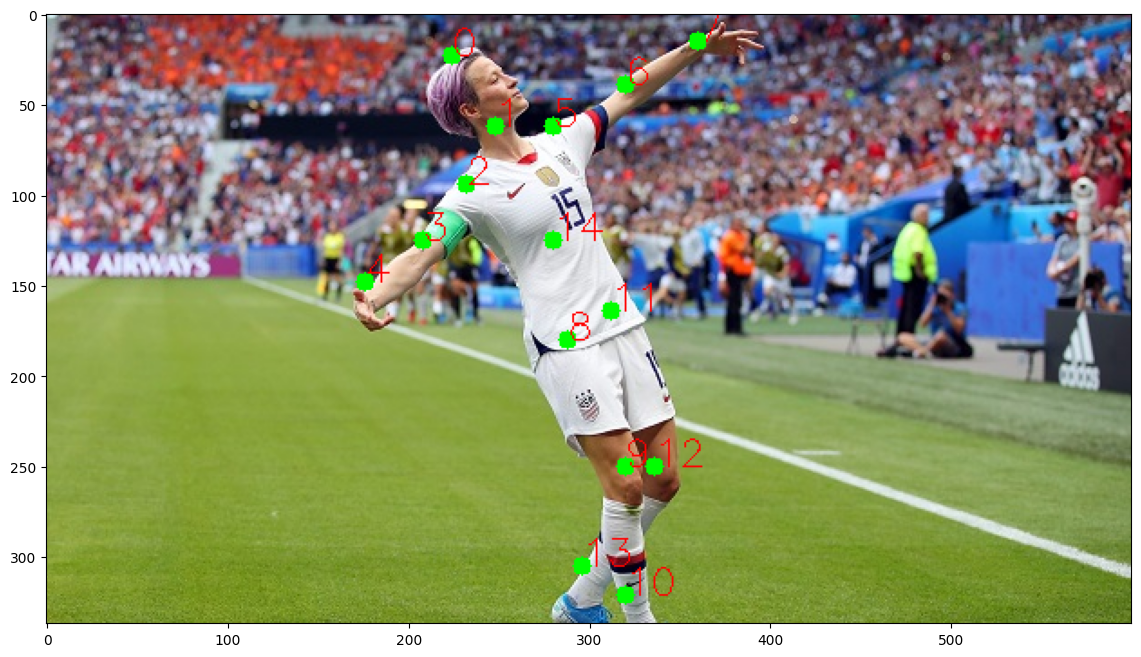

In [20]:
plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [21]:
point_connections = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10],[14,11],[11,12],[12,13]]
# 추출한 바디 포인터를 사람이 보기 쉽게 선으로 연
point_connections

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [22]:
for connection in point_connections :
  partA = connection[0]
  partB = connection[1]

  if points[partA] and points[partB]:
    cv2.line(image,points[partA], points[partB], (255,0,0))

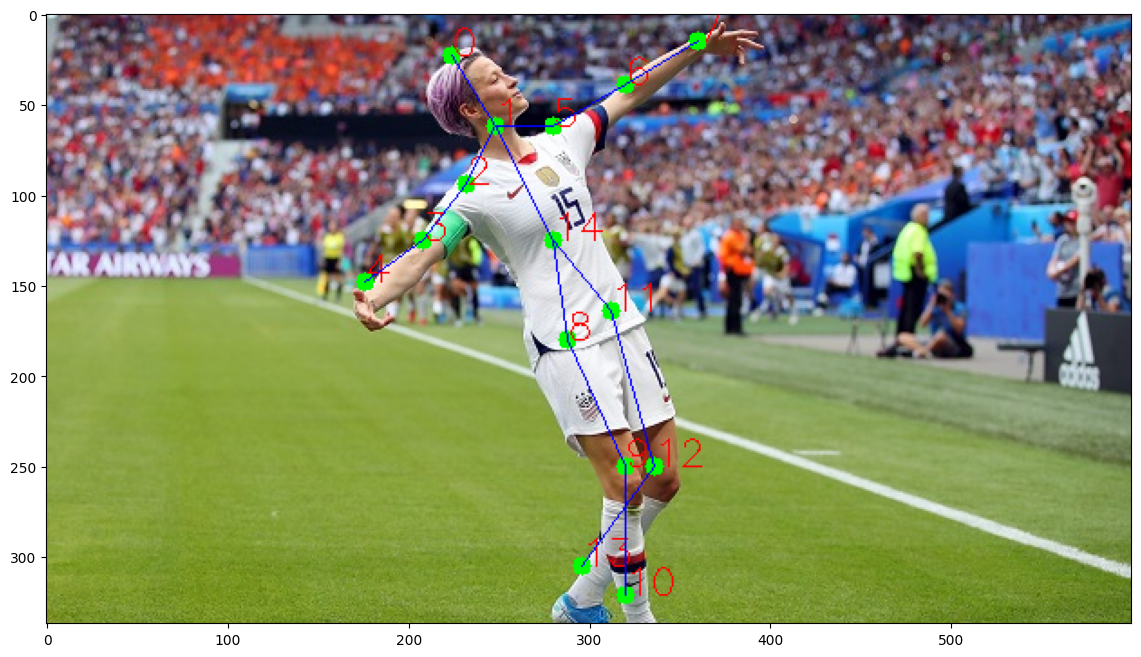

In [23]:
plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Detectiong movements (arms above the head)
- 이미지 및 영상에서 각각의 body point를 감지하고 탐지한 body point를 이용하여 만세등 각각의 행위및 제스쳐를 감지하기.

### Arms above the head in image
- 양 손이 머리보다 이미지 상 위에 있다면 만세로 감지한다.

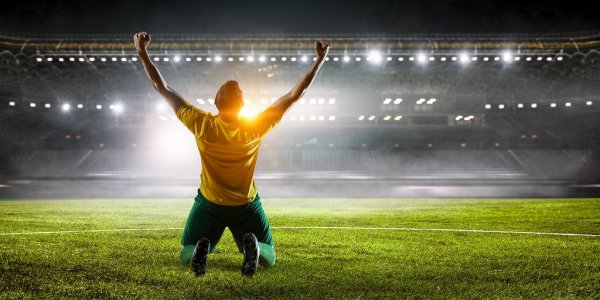

In [24]:
image2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/player.jpg')
cv2_imshow(image2)

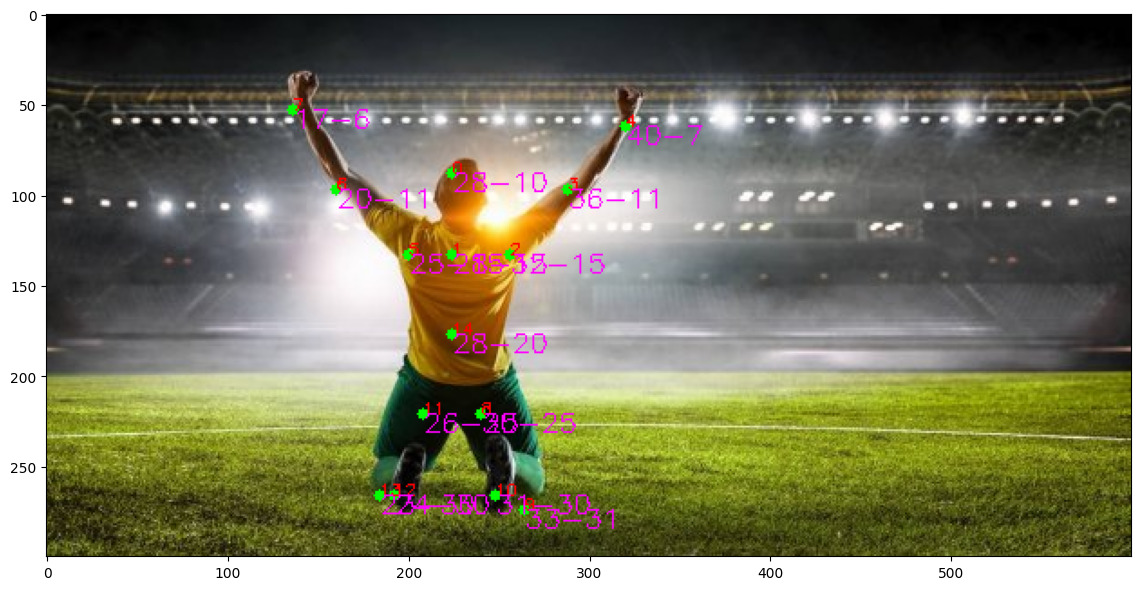

In [25]:
# 이미지 불러오기
image2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/player.jpg')
# 이미지 전처리
image_blob2 = cv2.dnn.blobFromImage(image = image2, scalefactor = 1.0/255,
                                   size = (image2.shape[1],image2.shape[0]))
# body point 예측
network.setInput(image_blob2)
output2 = network.forward()

# 데이터 시각화
position_width = output2.shape[3]
position_height = output2.shape[2]

num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
  confidence_map = output2[0,i, :, :]
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  x= int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_height)
  if confidence  > threshold:
    cv2.circle(image2, (x,y), 3, (0,255,0), thickness = -1)
    cv2.putText(image2, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255))
    # 각각의 body point의 위치를 이미지에 시각화하여 분석하면 편하다.
    # 너비 - 높이 형식으로 출력된다. 높이는 0에 가까울수록 높은것이고 너비는 75에 가까울수록 오른쪽이다.
    cv2.putText(image2, '{}-{}'.format(point[0], point[1]), (x,y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255))

    points.append((x,y))
  else:
    points.append(None)

plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB));

In [1]:
# 제스처 확인 함수

# 이미지 분석때 생성한 points리스트(각각의 바디포인트의 위치를 담고있는)를 매개변수로 입력
def verify_arms_up(points):
  head, right_wrist, left_wrist = 0,0,0
  for i, point in enumerate(points):
    if i == 0 :# 머리
      head = point[1]#높이를 사용하기 때문에 point[1]만 참조 ,(가로, 높이)
    elif i == 4 :# 오른쪽 손
      right_wrist = point[1]
    elif i == 7 :# 왼쪽 손
      left_wrist = point[1]

  if right_wrist < head and left_wrist < head:
    return True
  else:
    return False

In [26]:
verify_arms_up(points)

True

### Arms above the head in Video
- 비디오의 각각의 프레임마다 탐지한 양 손이 머리보다 위에 있다면 만세로 감지한다.


In [42]:
video = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Videos/gesture1.mp4'
capture = cv2.VideoCapture(video)
connected, frame = capture.read()
connected

True

In [43]:
frame.shape

(1080, 808, 3)

In [44]:
# 모션 탐지한 결과 비디오 저장하기
result = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/Recognition of Gestures and Actions/gesture1_result.mp4'
#cv2.VideoWriter('경로', '비디오 코덱 설정', '초당 FPS', ('영상 해상도 y값','영상 해상 x값'))
# FPS값이 크면 일초에 많은 프레임이 저장되니깐 영상길이는 짧아진다.
save_video=cv2.VideoWriter(result, cv2.VideoWriter_fourcc(*'XVID'),10,(frame.shape[1], frame.shape[0]))

In [ ]:
# 각각의 프레임마다 바디포인트 체크
threshold = 0.1

while cv2.waitKey(1) < 0: # 키가 눌리지 않는다면 무한 반복
  connected, frame = capture.read()

  if not connected :
    break

  # bodypoint 추출 시작
  image_blob = cv2.dnn.blobFromImage(image = frame, scalefactor = 1.0/255,
                                   size = (256,256))
  network.setInput(image_blob)
  output = network.forward()


  position_width = output.shape[3]
  position_height = output.shape[2]

  num_points = 15
  points = []
  for i in range(num_points):
    confidence_map = output[0,i, :, :]
    _, confidence, _, point = cv2.minMaxLoc(confidence_map)
    x= int((frame.shape[1] * point[0]) / position_width)
    y = int((frame.shape[0] * point[1]) / position_height)
    if confidence  > threshold:
      cv2.circle(frame, (x,y), 5, (0,255,0), thickness = -1)
      cv2.putText(frame, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255))
      points.append((x,y))
    else:
      points.append(None)

  for connection in point_connections :
    partA = connection[0]
    partB = connection[1]

    if points[partA] and points[partB]:
      cv2.line(frame,points[partA], points[partB], (255,0,0))

  # True이면 frame에 Complete 글자쓰기
  if verify_arms_up(points) == True:
    cv2.putText(frame, 'Complete', (50,200), cv2.FONT_HERSHEY_COMPLEX, 3, (0,0,255))


  #cv2_imshow(frame)
  # 저장할 비디오에 현재 프레임을 하나씩 저장
  save_video.write(frame)
# 모든 프레임이 저장되면 이전에 설정한 정보로 비디오 저장
save_video.release()